Docs:
- https://juliasilge.com/blog/intro-tidymodels/

In [16]:
url_attendance = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-04/attendance.csv"
url_standing = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-04/standings.csv"

In [17]:
### Importing the data

In [18]:
import pandas as pd
df_attendance = pd.read_csv(url_attendance)
df_standing = pd.read_csv(url_standing)

In [19]:
# import polars as pl

# df_attendance = pl.scan_csv(url_attendance)
# df_standing = pl.scan_csv(url_standing)

In [20]:
df_attendance.head()

,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0
2,Arizona,Cardinals,2000,893926,387475,506451,3,NaN
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0


In [21]:
df_standing.head()

,team,team_name,year,wins,loss,points_for,points_against,points_differential,margin_of_victory,strength_of_schedule,simple_rating,offensive_ranking,defensive_ranking,playoffs,sb_winner
0,Miami,Dolphins,2000,11,5,323,226,97,6.1,1.0,7.1,0.0,7.1,Playoffs,No Superbowl
1,Indianapolis,Colts,2000,10,6,429,326,103,6.4,1.5,7.9,7.1,0.8,Playoffs,No Superbowl
2,New York,Jets,2000,9,7,321,321,0,0.0,3.5,3.5,1.4,2.2,No Playoffs,No Superbowl
3,Buffalo,Bills,2000,8,8,315,350,-35,-2.2,2.2,0.0,0.5,-0.5,No Playoffs,No Superbowl
4,New England,Patriots,2000,5,11,276,338,-62,-3.9,1.4,-2.5,-2.7,0.2,No Playoffs,No Superbowl


In [22]:
print(df_attendance.shape)
print(df_standing.shape)

(10846, 8)
(638, 15)


In [57]:
df = df_attendance.merge(df_standing, how='left', on=['team', 'team_name', 'year'])

### EDA

- How does attendance vary in-season vs during playoffs
- How does attendance vary based on team win records?
- How does attendance vary during the season (is there seasonality)?


In [43]:
import matplotlib.pyplot as plt 

In [28]:
import seaborn as sns

t = df.groupby(by=['team_name', 'playoffs'])['weekly_attendance'].agg(['mean', 'median', 'max']).reset_index()

In [35]:
t

,team_name,playoffs,mean,median,max
0,49ers,No Playoffs,67726.321429,68098.5,103467.0
1,49ers,Playoffs,67471.520833,69143.5,83559.0
2,Bears,No Playoffs,65208.354167,62433.0,90554.0
3,Bears,Playoffs,64892.550000,62359.5,90138.0
4,Bengals,No Playoffs,62960.451923,64922.5,91653.0
...,...,...,...,...,...
59,Texans,Playoffs,68781.427083,71644.5,84771.0
60,Titans,No Playoffs,67090.605769,69129.5,90616.0
61,Titans,Playoffs,67001.241071,68804.0,83472.0
62,Vikings,No Playoffs,65655.578125,64128.0,90608.0


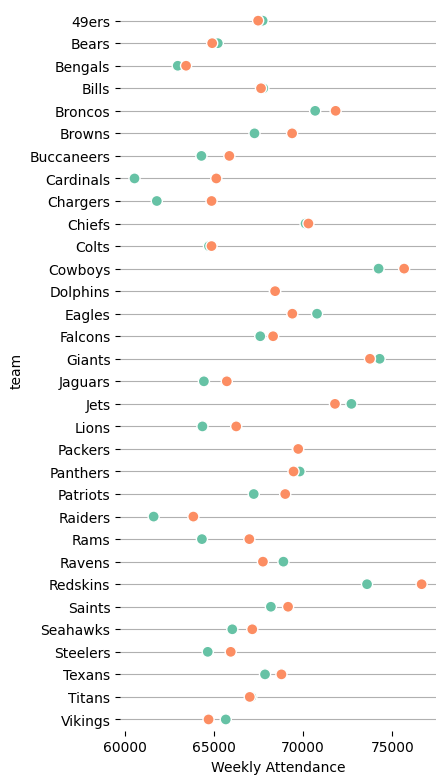

In [38]:
# --- Team Attendance - regular season vs playoffs

g = sns.PairGrid(
    t.sort_values("mean", ascending=False),
    x_vars=["mean"],
    y_vars=["team_name"],
    height=8,
    aspect=0.5
)
g.map(
    sns.stripplot,
    orient="h",
    size=8,
    jitter=False,
    hue=t["playoffs"],
    palette="Set2",
    linewidth=1,
    edgecolor="white"
)
g.set(xlabel="Weekly Attendance", ylabel="Team")
for ax in g.axes.flat:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

In [45]:
# --- Team Attendance - team win records
# ax = sns.scatterplot(data=df, x="simple_rating", y="weekly_attendance", hue="team_name")
# plt.show()

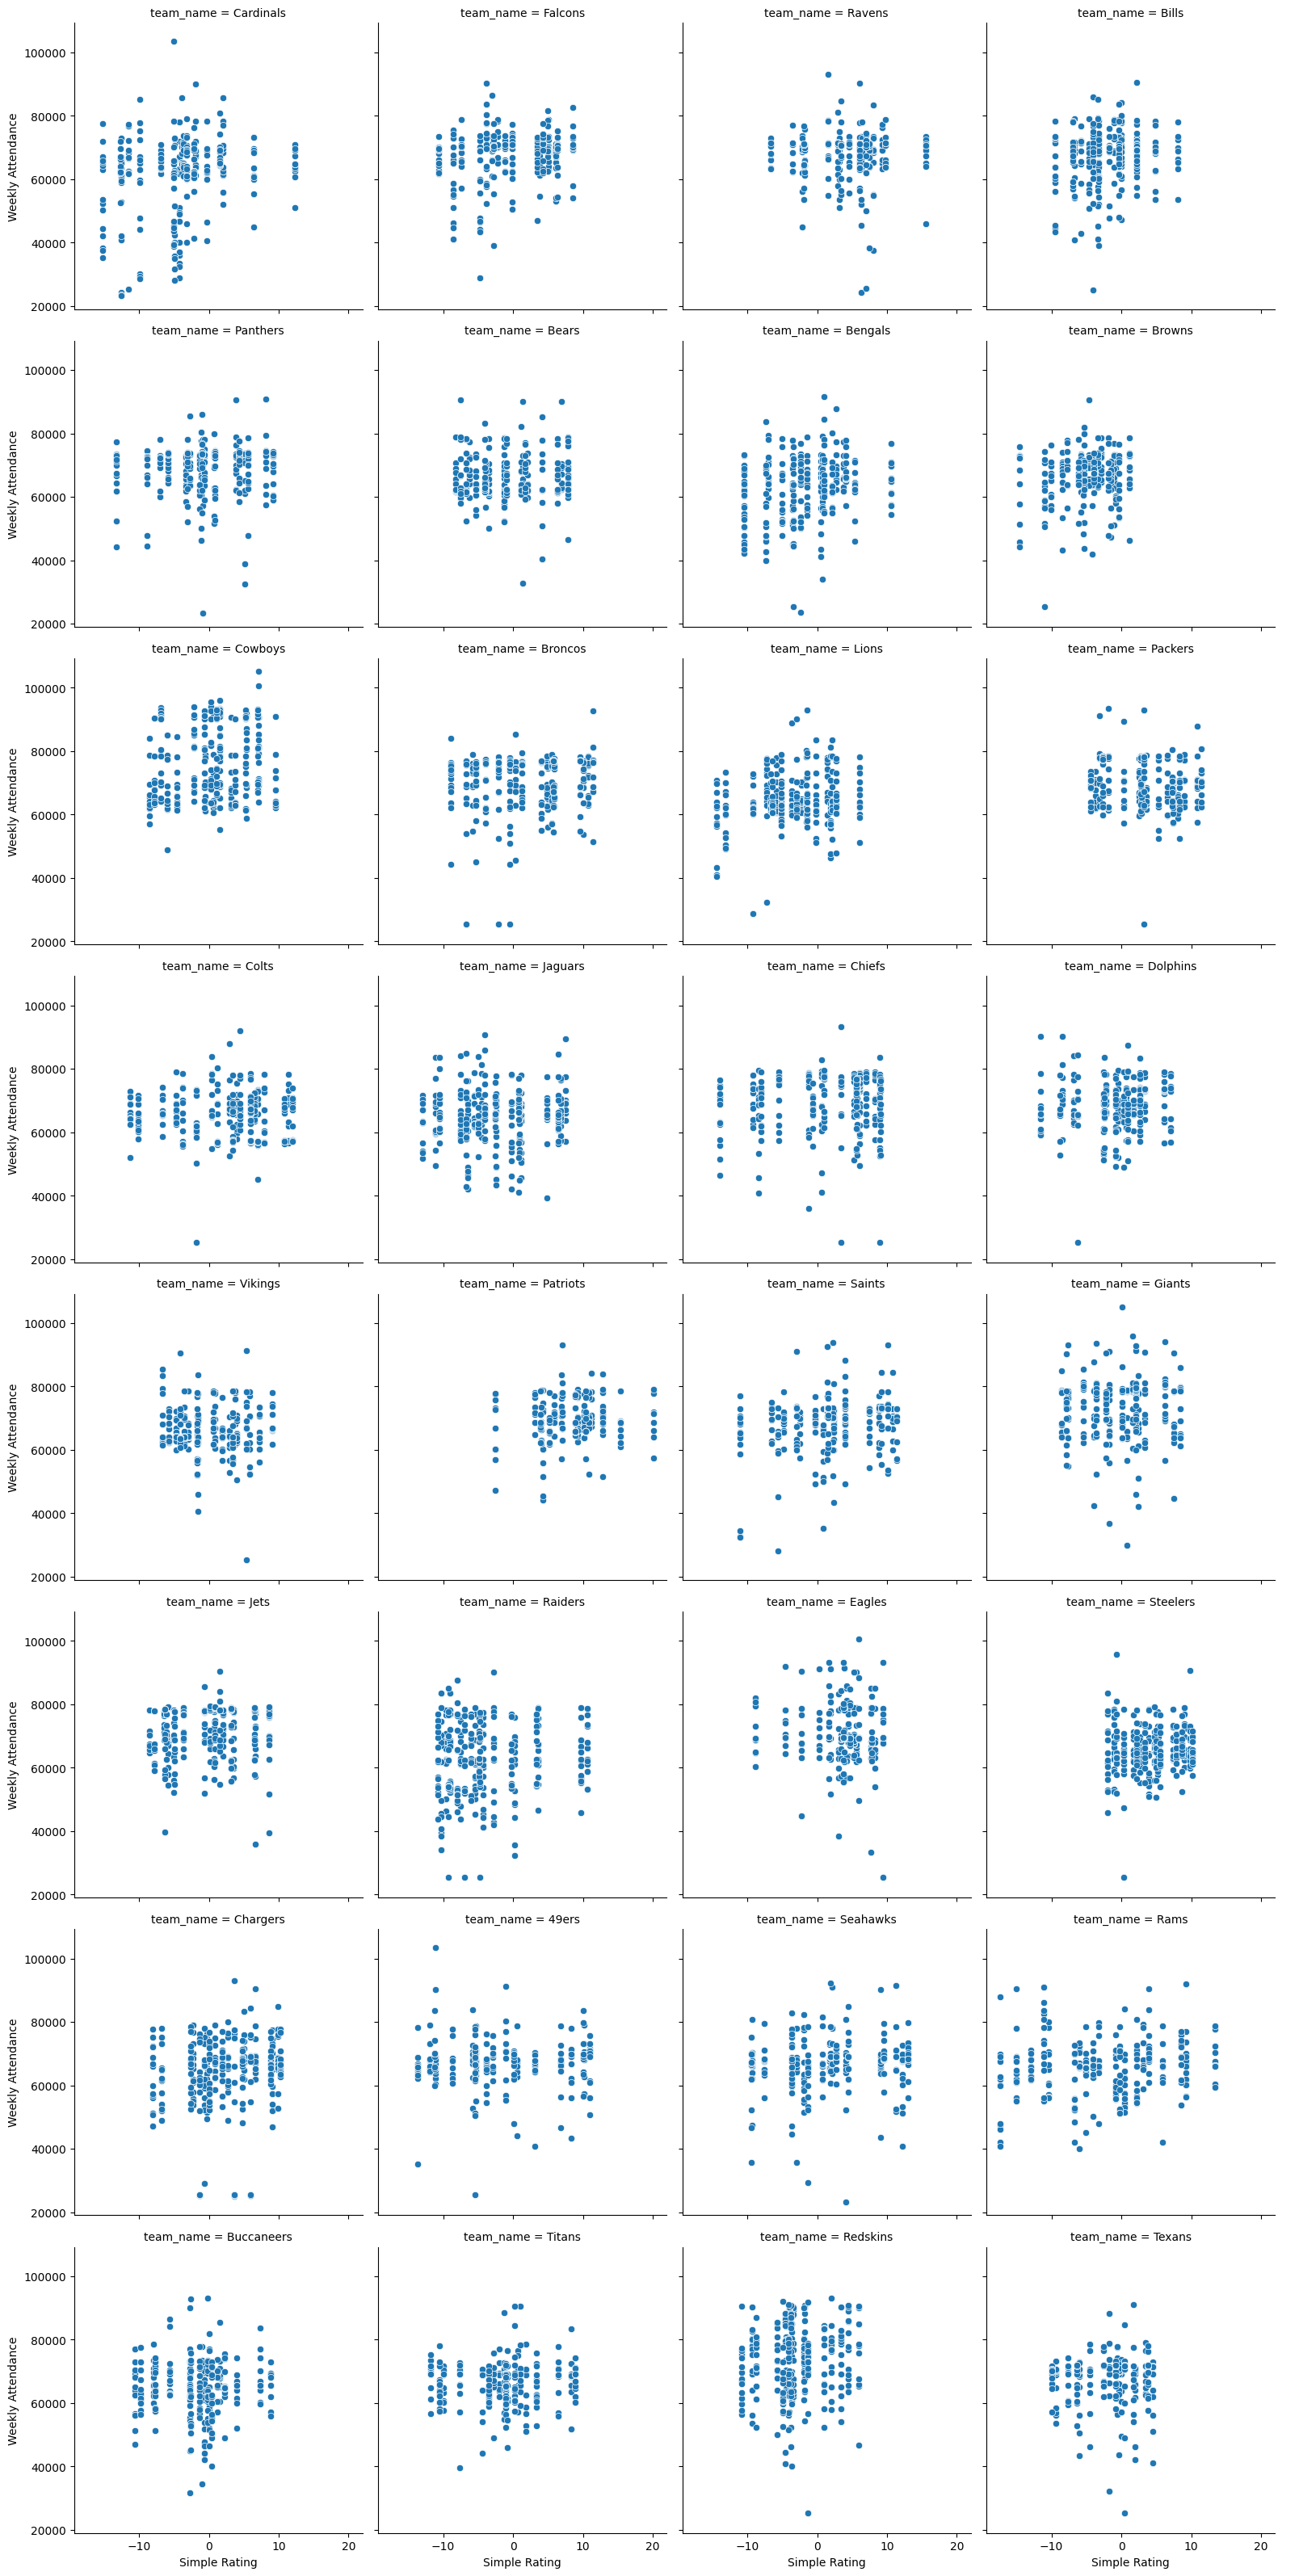

In [44]:
g = sns.FacetGrid(df, col="team_name", col_wrap=4, height=4)
g.map_dataframe(sns.scatterplot, x="simple_rating", y="weekly_attendance")
g.set_axis_labels("Simple Rating", "Weekly Attendance")
g.add_legend()
plt.show()

In [52]:
df_standing['sb_winner'].unique()

array(['No Superbowl', 'Won Superbowl'], dtype=object)

## Model

- x: playoffs, team_name, week, simple_rating
- y: weekly_attendance

In [145]:
# dff = df.copy()
df = dff.copy()

In [146]:
df_superbowl = df_standing[df_standing['sb_winner'] == 'Won Superbowl'].groupby(by=['team_name'])['sb_winner'].count().reset_index()

In [147]:
from collections import defaultdict

team_superbowl_map = defaultdict()
for team, val in df_superbowl.to_dict("split")['data']:
    team_superbowl_map[team] = val

team_mapping = {name: team_superbowl_map.get(name, 0) for name in df_standing['team_name'].unique()}

In [148]:
df['sb_winner'] = df['sb_winner'].map({'No Superbowl': 0, 'Won Superbowl': 1})
df['playoffs'] = df['playoffs'].map({"No Playoffs": 0, "Playoffs": 1})
df['team_name'] = df['team_name'].map(team_mapping)

In [149]:
# print(df.isna().values.any())
# print(df.isna().sum())
df = df[~df['weekly_attendance'].isna()]
# print(df.isna().sum())

In [150]:
from sklearn.model_selection import train_test_split

feature_names = ['team_name', 'playoffs', 'week', 'simple_rating']
X = df[feature_names]
y = df['weekly_attendance']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, stratify=X['playoffs']
)

In [151]:
from sklearn.preprocessing import MinMaxScaler

week_scalar_train = MinMaxScaler()
week_scalar_train.fit(X_train[['week']])
X_train['week'] = week_scalar_train.transform(X_train[['week']])

rating_scalar_train = MinMaxScaler()
rating_scalar_train.fit(X_train[['simple_rating']])
X_train['simple_rating'] = rating_scalar_train.transform(X_train[['simple_rating']])
                      

In [152]:
week_scalar_test = MinMaxScaler()
week_scalar_test.fit(X_test[['week']])
X_test['week'] = week_scalar_test.transform(X_test[['week']])

rating_scalar_test = MinMaxScaler()
rating_scalar_test.fit(X_test[['simple_rating']])
X_test['simple_rating'] = rating_scalar_test.transform(X_test[['simple_rating']])

### Linear Regression

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
reg_mse = mean_squared_error(y_pred, y_test)

In [154]:
reg_mse

76869808.8868899

In [156]:
# for pred, real in zip(y_pred, y_test):
#     print(pred, real)

In [158]:
# intepretation - weight effect plot
weights = reg.coef_

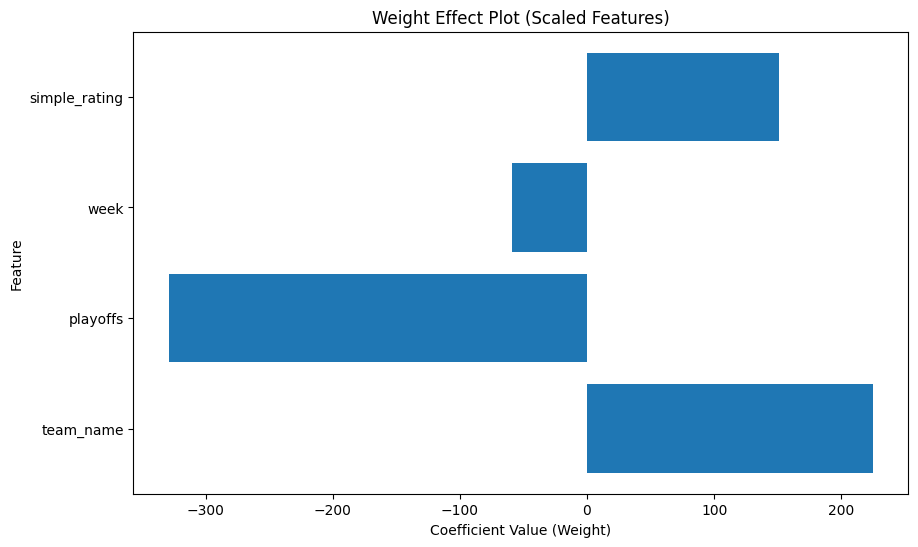

In [161]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights)
plt.xlabel('Coefficient Value (Weight)')
plt.ylabel('Feature')
plt.title('Weight Effect Plot (Scaled Features)')
plt.show()

### Random Forest


In [162]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
reg_mse = mean_squared_error(y_pred, y_test)

In [165]:
weights = rf.feature_importances_

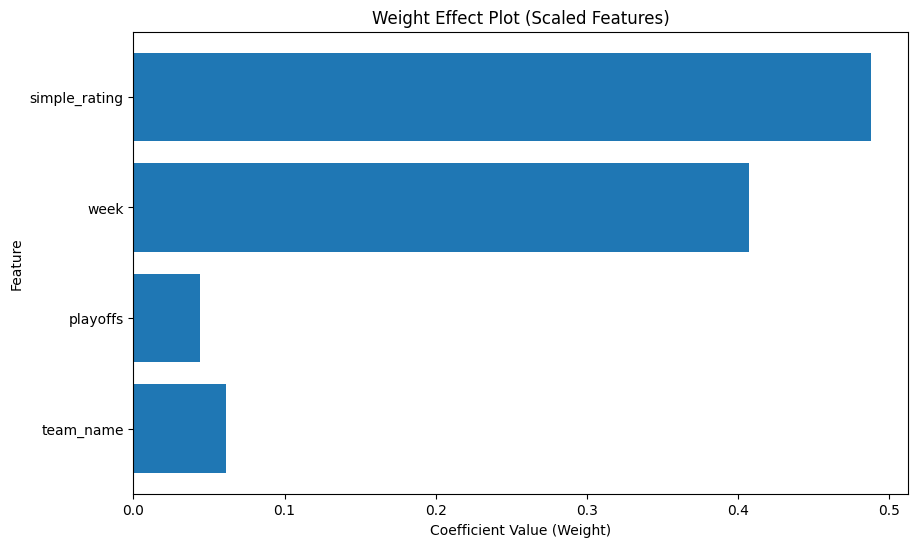

In [166]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights)
plt.xlabel('Coefficient Value (Weight)')
plt.ylabel('Feature')
plt.title('Weight Effect Plot (Scaled Features)')
plt.show()